# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения

## Подготовка данных

Загркзка библиотек

In [1]:
import time as t
tglobal = t.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

!pip install catboost -q
from catboost import CatBoostRegressor
from catboost.metrics import RMSE

!pip install lightgbm -q
!pip install xgboost -q
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install optuna -q
import optuna

!pip install skimpy --q
from skimpy import clean_columns

sns.set(rc={'figure.figsize':(10,6)})

Вспомогашки для обзора данных

In [2]:
class colors:
    HEADER = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
def loses (df):
    len_loses = np.sum(df.isna(), axis=1)!=0
    len_loses = len_loses.sum()
    
    len_data = df.shape[0]
    
    loses_frac = len_loses / len_data
    
    print(f'В выборке {len_loses} строк с пропусками')
    print(f'Это составляет {loses_frac:.2%} от всей выборки')

In [4]:
def data_overview (df):
    print(colors.BOLD + 'Dataset info' + colors.ENDC)
    print(df.info())
    print()
    
    print(colors.BOLD + 'Duplicates:' + colors.ENDC)
    print('Count:', df.duplicated().sum())
    print('Percent:', df.duplicated().sum()/len(df))
    print()
    
    print(colors.BOLD + "NaN's" + colors.ENDC)
    display(pd.concat([df.isna().sum().rename('nan_count'), 
                   df.isna().mean().rename('nan_percent'),
                   df.nunique().rename('unique_values')], 
                  axis=1))
    
    len_loses = np.sum(df.isna(), axis=1)!=0
    len_loses = len_loses.sum()
    len_data = df.shape[0]
    loses_frac = len_loses / len_data
    print(colors.BOLD + f'В выборке {len_loses} строк с пропусками' + colors.ENDC)
    print(colors.BOLD + f'Это составляет {loses_frac:.2%} от всей выборки' + colors.ENDC)


    print()
    
    print(colors.BOLD + 'Numeric cols description' + colors.ENDC)
    print(df.describe())
    df.hist(bins=50, figsize=(19,10))
    #plt.show()

Загрузка и обзор данных

In [6]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
4709,2016-03-10 21:55:47,1800,coupe,2000,manual,0,clk,150000,10,petrol,mercedes_benz,no,2016-03-10 00:00:00,0,45661,2016-03-12 14:16:33
110723,2016-03-17 21:53:40,14990,wagon,2009,manual,170,a6,70000,3,petrol,audi,no,2016-03-17 00:00:00,0,88499,2016-03-29 05:15:31
76332,2016-03-17 11:25:25,500,sedan,1999,manual,136,galant,150000,12,petrol,mitsubishi,no,2016-03-17 00:00:00,0,60433,2016-03-31 06:15:37
83622,2016-03-29 13:58:36,2000,wagon,2002,manual,145,mondeo,150000,2,petrol,ford,no,2016-03-29 00:00:00,0,74831,2016-04-06 00:15:26
220943,2016-03-11 13:46:24,2899,wagon,2002,manual,170,3er,150000,3,petrol,bmw,no,2016-03-11 00:00:00,0,12349,2016-03-12 03:15:53


Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

,nan_count,nan_percent,unique_values
DateCrawled,0,0.000000,271174
Price,0,0.000000,3731
VehicleType,37490,0.105794,8
RegistrationYear,0,0.000000,151
Gearbox,19833,0.055967,2
Power,0,0.000000,712
Model,19705,0.055606,250
Kilometer,0,0.000000,13
RegistrationMonth,0,0.000000,13
FuelType,32895,0.092827,7


В выборке 108555 строк с пропусками
Это составляет 30.63% от всей выборки

Numeric cols description
               Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min        

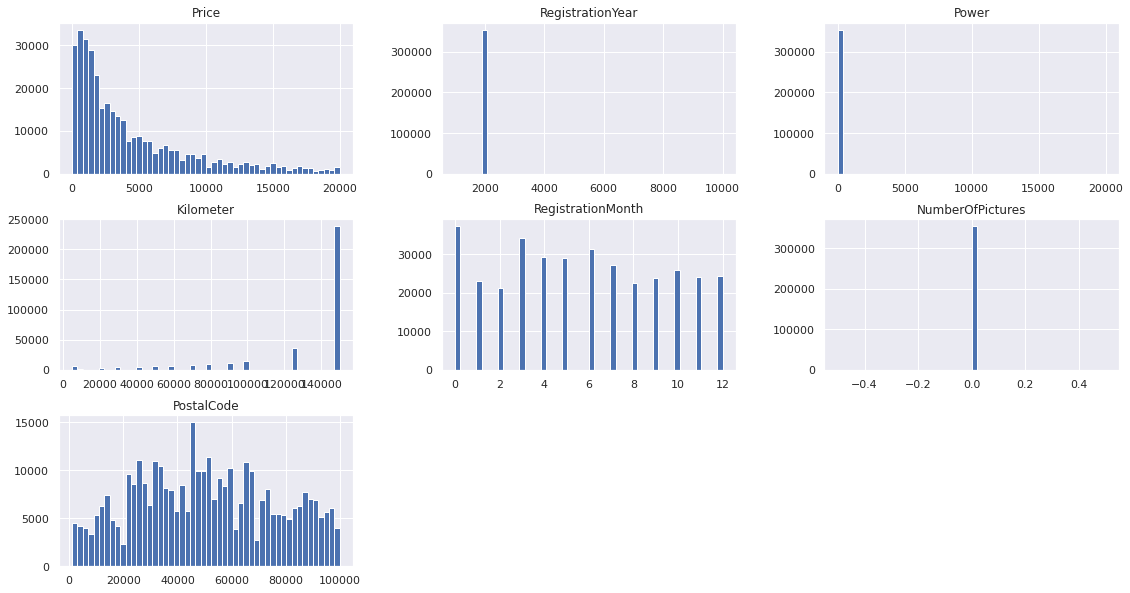

In [7]:
data_overview(df)

- Представлена информация о более чем 354 тыс. объявлений
- Объявления описаны через 7 числовых признаков, 3 признака с датами и 6 категориальных
- Содержит 4 явных дубликата (учитывая наличие 3 столбцов с датами их может быть гораздо больше)
- Почти 1/3 данных содержит пропуски
- Столбцы с ценой, годом регистрации и мощностью двигателя явно содержат выбросы (цена 0 евро, год регистрации 9999, и мощность от 0 до 20000 лошадиных сил, при том что танкеры или круизные лайнеры скорее всего в списке отсутствуют)
- Столбец с количеством фотографий по сути не содержит ценной для предсказания цены информации (все значения равны 0)

## Предобработка данных

Переименуем столбцы для удобства

In [8]:
df = clean_columns(df)
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'reg_year', 'gearbox', 'power',
       'model', 'kilometer', 'reg_month', 'fuel_type', 'brand', 'not_rep',
       'date_created', 'num_of_pict', 'postalcode', 'lastseen'],
      dtype='object')

Сразу удалим столбец с количеством фото

In [9]:
df = df.drop('num_of_pict',axis=1)

Из признаков-дат можно получить возраст автомобиля

In [10]:
df['age'] = pd.to_datetime(df['date_crawled']).dt.year - df['reg_year']

### Дубликаты

Проверим дубликаты без учета дат

In [11]:
date_col = ['date_crawled','date_created','lastseen']
without_date_col = set(df.columns) - set(date_col)

Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   not_rep       283215 non-null  object
 1   power         354369 non-null  int64 
 2   vehicle_type  316879 non-null  object
 3   reg_year      354369 non-null  int64 
 4   age           354369 non-null  int64 
 5   price         354369 non-null  int64 
 6   postalcode    354369 non-null  int64 
 7   gearbox       334536 non-null  object
 8   fuel_type     321474 non-null  object
 9   brand         354369 non-null  object
 10  kilometer     354369 non-null  int64 
 11  model         334664 non-null  object
 12  reg_month     354369 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.1+ MB
None

Duplicates:
Count: 21333
Percent: 0.06019996105754172

NaN's


,nan_count,nan_percent,unique_values
not_rep,71154,0.200791,2
power,0,0.000000,712
vehicle_type,37490,0.105794,8
reg_year,0,0.000000,151
age,0,0.000000,151
price,0,0.000000,3731
postalcode,0,0.000000,8143
gearbox,19833,0.055967,2
fuel_type,32895,0.092827,7
brand,0,0.000000,40


В выборке 108555 строк с пропусками
Это составляет 30.63% от всей выборки

Numeric cols description
               power       reg_year            age          price  \
count  354369.000000  354369.000000  354369.000000  354369.000000   
mean      110.094337    2004.234448      11.765552    4416.656776   
std       189.850405      90.227958      90.227958    4514.158514   
min         0.000000    1000.000000   -7983.000000       0.000000   
25%        69.000000    1999.000000       8.000000    1050.000000   
50%       105.000000    2003.000000      13.000000    2700.000000   
75%       143.000000    2008.000000      17.000000    6400.000000   
max     20000.000000    9999.000000    1016.000000   20000.000000   

          postalcode      kilometer      reg_month  
count  354369.000000  354369.000000  354369.000000  
mean    50508.689087  128211.172535       5.714645  
std     25783.096248   37905.341530       3.726421  
min      1067.000000    5000.000000       0.000000  
25%     30165

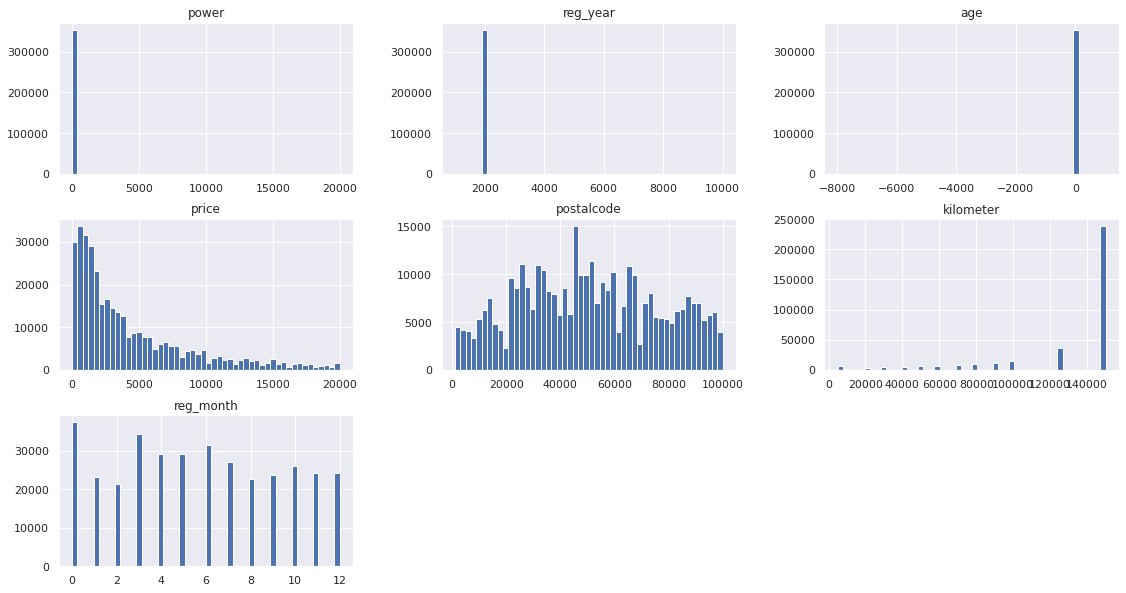

In [12]:
data_overview(df[without_date_col])

Без учета дат количество дубликатов возрастает до 21333 (около 6%)

Для дальнейшей работы с данными от всех столбцов с датами (в том числе представленными в виде одиночных чисел) можно избавиться

In [13]:
df = df.drop(['date_crawled','reg_year','reg_month','date_created','lastseen'],axis=1)
df.sample(5)

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_rep,postalcode,age
348668,1000,wagon,manual,2598,a6,150000,NaN,audi,NaN,7646,20
333592,3000,wagon,auto,218,omega,150000,petrol,opel,no,36326,14
282826,1250,sedan,manual,131,a4,150000,petrol,audi,no,16515,15
251621,11900,convertible,manual,220,boxster,150000,petrol,porsche,NaN,73614,14
323712,4200,small,manual,68,fiesta,150000,gasoline,ford,no,97337,8


И подчистим дубликаты в последний раз

In [14]:
df = df.drop_duplicates()
df.shape

(330858, 11)

Dataset info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 330858 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         330858 non-null  int64 
 1   vehicle_type  294839 non-null  object
 2   gearbox       311998 non-null  object
 3   power         330858 non-null  int64 
 4   model         311894 non-null  object
 5   kilometer     330858 non-null  int64 
 6   fuel_type     299029 non-null  object
 7   brand         330858 non-null  object
 8   not_rep       263235 non-null  object
 9   postalcode    330858 non-null  int64 
 10  age           330858 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 30.3+ MB
None

Duplicates:
Count: 0
Percent: 0.0

NaN's


,nan_count,nan_percent,unique_values
price,0,0.000000,3731
vehicle_type,36019,0.108865,8
gearbox,18860,0.057003,2
power,0,0.000000,712
model,18964,0.057318,250
kilometer,0,0.000000,13
fuel_type,31829,0.096201,7
brand,0,0.000000,40
not_rep,67623,0.204387,2
postalcode,0,0.000000,8143


В выборке 103794 строк с пропусками
Это составляет 31.37% от всей выборки

Numeric cols description
               price          power      kilometer     postalcode  \
count  330858.000000  330858.000000  330858.000000  330858.000000   
mean     4381.797517     109.799536  128253.072315   50711.282886   
std      4506.414298     194.855656   37943.148027   25812.489833   
min         0.000000       0.000000    5000.000000    1067.000000   
25%      1000.000000      68.000000  125000.000000   30179.000000   
50%      2699.000000     103.000000  150000.000000   49492.000000   
75%      6300.000000     140.000000  150000.000000   71364.000000   
max     20000.000000   20000.000000  150000.000000   99998.000000   

                 age  
count  330858.000000  
mean       11.820452  
std        89.511121  
min     -7983.000000  
25%         8.000000  
50%        13.000000  
75%        17.000000  
max      1016.000000  


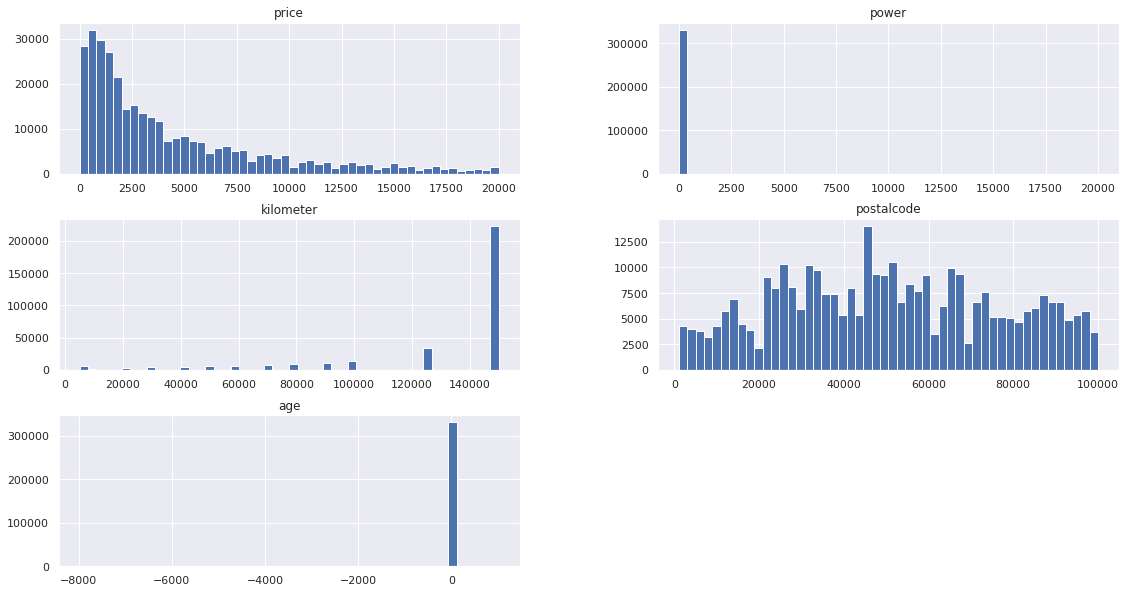

In [15]:
data_overview(df)

### Выбросы

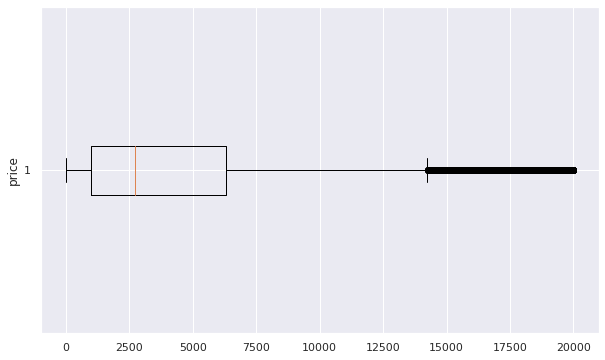

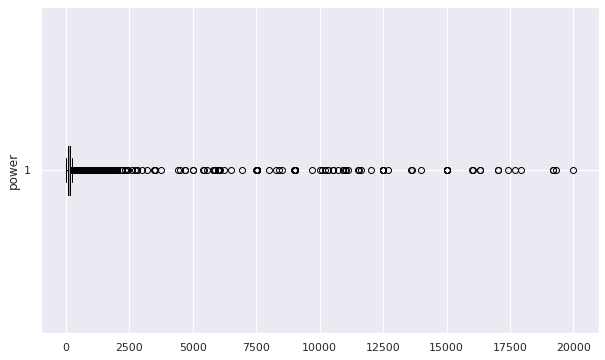

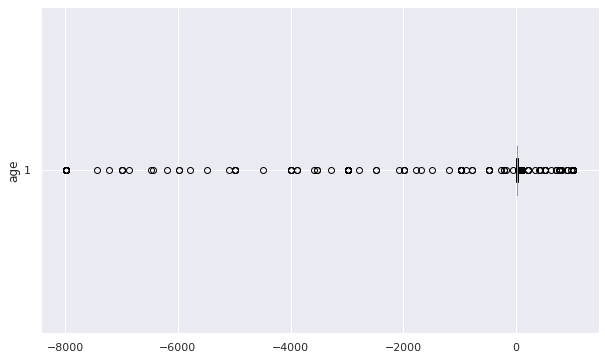

In [16]:
for x in ['price','power','age']:
    plt.boxplot(df[x],vert=False)
    plt.ylabel(x)
    plt.show()

- **Цена** 

 - Цены начитаются с 0. Это явно нерелевантные для предсказания значения. Возможно некорректно оформленные объявления или его автор предлагает установить цену возможному покупателю и торговаться, возможны и другие причины. Следует установить минимальное значение цены хотя бы в 50 EUR чтобы избавиться от таких записей
    
- **Мощность**

 - Самый мощный "гражданский" автомобильный двигатель на текущий момент (08.2022) выдает 2150 л.с.* Чтобы перестраховаться за верхнюю границу возьмем 2300 л.с. Такое высокое значение тоже может отразиться на итоговом качестве модели, но попробуем
  - Как запасной вариант оставим 500 л.с.
 - В то же время самый маломощный автомобиль оснащен двигателем 4 л.с.** 
    
- **Возраст**

 - Отрицательным возраст быть не может
   
---   
`*` по данным https://soulcar.ru/top-35-samyx-moshhnyx-avtomobilej-v-mire-2022-goda/obzory/ 

`**` по данным https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html


In [17]:
df.loc[df['price'] < 50,'price'] = np.nan
df.loc[(df['power'] > 2300) | (df['power'] < 4),'power'] = np.nan
df.loc[df['age']<0,'age'] = np.nan

df = df.dropna(subset=['price','power','age'])

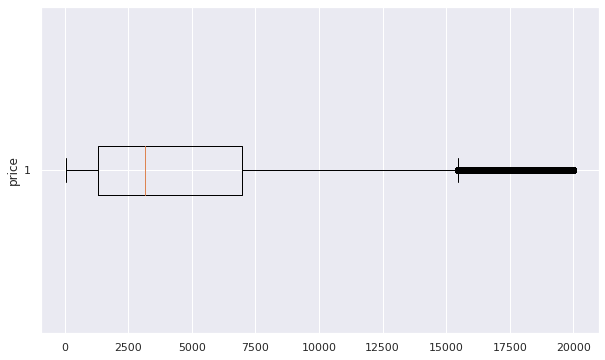

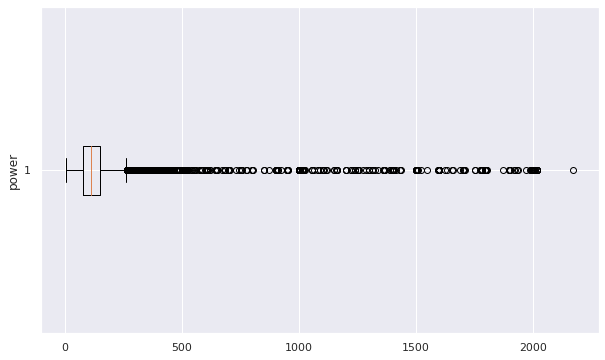

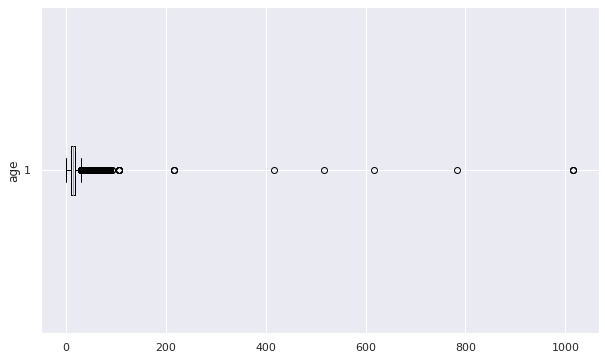

In [18]:
for x in ['price','power','age']:
    plt.boxplot(df[x],vert=False)
    plt.ylabel(x)
    plt.show()

Избавимся также от 100-летних автомобилей

In [19]:
df.loc[df['age']>100,'age'] = np.nan

df = df.dropna(subset=['age'])

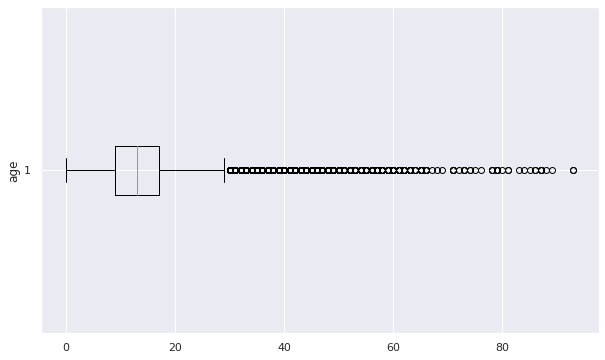

In [20]:
plt.boxplot(df['age'],vert=False)
plt.ylabel('age');

Dataset info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 275582 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         275582 non-null  float64
 1   vehicle_type  264966 non-null  object 
 2   gearbox       270381 non-null  object 
 3   power         275582 non-null  float64
 4   model         264879 non-null  object 
 5   kilometer     275582 non-null  int64  
 6   fuel_type     260507 non-null  object 
 7   brand         275582 non-null  object 
 8   not_rep       234680 non-null  object 
 9   postalcode    275582 non-null  int64  
 10  age           275582 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 25.2+ MB
None

Duplicates:
Count: 0
Percent: 0.0

NaN's


,nan_count,nan_percent,unique_values
price,0,0.000000,3565
vehicle_type,10616,0.038522,8
gearbox,5201,0.018873,2
power,0,0.000000,595
model,10703,0.038838,249
kilometer,0,0.000000,13
fuel_type,15075,0.054702,7
brand,0,0.000000,40
not_rep,40902,0.148420,2
postalcode,0,0.000000,8116


В выборке 60642 строк с пропусками
Это составляет 22.01% от всей выборки

Numeric cols description
               price          power      kilometer     postalcode  \
count  275582.000000  275582.000000  275582.000000  275582.000000   
mean     4830.289939     121.318399  128378.232250   51453.758700   
std      4606.340949      64.798826   36745.537618   25796.447535   
min        50.000000       4.000000    5000.000000    1067.000000   
25%      1300.000000      75.000000  125000.000000   31061.000000   
50%      3150.000000     110.000000  150000.000000   50389.000000   
75%      6970.000000     150.000000  150000.000000   72336.000000   
max     20000.000000    2172.000000  150000.000000   99998.000000   

                 age  
count  275582.000000  
mean       13.218360  
std         6.574396  
min         0.000000  
25%         9.000000  
50%        13.000000  
75%        17.000000  
max        93.000000  


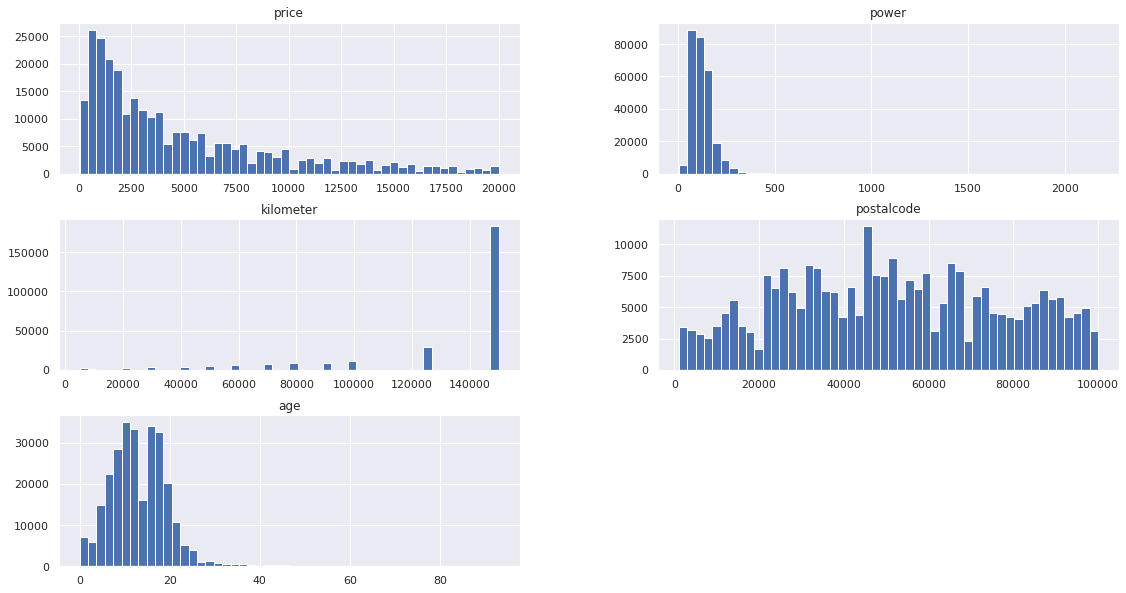

In [21]:
data_overview(df)

### Пропуски

Наибольшее количество пропусков осталось в столбце указывающем на то была машина в ремонте или нет.

В целом, это можно понять. Кто-то просто забыл заполнить, кто-то решил что ремонт был не значительным, но постеснялся откровенно врать, а кто-то надеется что покупатель ничего не найдет.

Так или иначе без, например, хранения исторических данных о объявлениях с однозначным определением конкретного автомобиля по VIN или доступа к базам ГИБДД достоверно заполнить эти пропуски невозможно.

Оставшиеся пропуски в данных заменим на значение `unknown` в надежде, что подели смогут что то из этого вытащить

In [22]:
df = df.fillna('unknown')
loses(df)

В выборке 0 строк с пропусками
Это составляет 0.00% от всей выборки


---

Для предотвращения появления таких "грязных" во многих смыслах объявлений создание словарей или связанных таблиц вида **бренд->модель->типкузова(_опционально_)->топливо->мощность->кпп** и перевести заполнение анкет на выпадающие списки или их более симпатичные аналоги.
    
В случае нестандартной конфигурации автомобиля (трековые, дрифтовые или внедорожные модификации) добавить необязательный чек-бокс и оставлять неполную анкету (например **бренд-модель-типкузова**) с обязательным заполнением текстового описания машины от продавца

Обучим следующие модели: 3 линейных (Lasso, Ridge, ElasticNet) и 2 бустинга (LightGBM, CatBoost)

***Выбранные бустинги не требуют преобразований категориальных признаков и могут работать с ними напрямую***

***Для линейных моделей воспользуемся OHE***

In [23]:
cat_features = ['vehicle_type', 'gearbox', 'model', 
                'fuel_type', 'brand', 'not_rep', 'postalcode']

df[cat_features] = df[cat_features].astype('category')

In [24]:
df_vanila = df.copy()
df_ohe = df.copy()

Для линейных моделей уберем признак `postalcode`. 

Формально он имеет числовые значения, но эти значения па сути категориальные и указывают на гороод, локацию в которой продается автомобиль. Если его не кодировать линейной модели это навредит, если кодировать - создадим огромное количество фичей (количество которых еще больше увеличится при расширении набора данных)

In [25]:
df_ohe = df_ohe.drop('postalcode',axis=1)
df_ohe = pd.get_dummies(df_ohe,drop_first=True)

In [26]:
target = df.price
features = df.drop(['price'],axis=1)

target_lr = df_ohe.price
features_lr = df_ohe.drop(['price'],axis=1)

In [27]:
features_train_full, features_test, target_train_full, target_test = train_test_split(
    features,
    target,
    test_size=.2,
    random_state=42
)

features_lr_train_full, features_lr_test, target_lr_train_full, target_lr_test = train_test_split(
    features_lr,
    target_lr, 
    test_size=.2, 
    random_state=42
)

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_full,
    target_train_full,
    test_size=.2,
    random_state=42
)

features_lr_train, features_lr_valid, target_lr_train, target_lr_valid = train_test_split(
    features_lr_train_full,
    target_lr_train_full, 
    test_size=.2, 
    random_state=42
)

In [29]:
results = pd.DataFrame({'model':[],
                   'fit_time':[],
                   'pred_time':[],
                   'rmse':[]})


### Baseline

In [30]:
model_name='baseline'
start = t.time()
dumdum = pd.Series(target_train.mean(),index=target_valid.index)
end_fit = t.time() - start
end_pred = 0

In [31]:
rmse = (np.sqrt(mean_squared_error(target_valid, dumdum)))

In [32]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

### Lasso

In [33]:
model_name = 'Lasso'
lasso = Lasso(normalize=True,
             random_state=42)

In [34]:
start = t.time()
lasso.fit(features_lr_train,target_lr_train)
end_fit = t.time() - start
print(f'Время обучения:{end_fit:.2f}')

Время обучения:1.81


In [35]:
start = t.time()
pred = lasso.predict(features_lr_valid)
end_pred = t.time() - start
print(f'Время обучения:{end_pred:.2f}')

Время обучения:0.23


In [36]:
rmse = (np.sqrt(mean_squared_error(target_lr_valid, pred)))
rmse

3249.1884161333437

In [37]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, ж эх 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

### Ridge

In [38]:
model_name='Ridge'
ridge = Ridge(normalize=True,
             random_state=42)

In [39]:
start = t.time()
ridge.fit(features_lr_train,target_lr_train)
end_fit = t.time() - start
print(f'Время обучения: {end_fit:.2f}')

Время обучения: 1.68


In [40]:
start = t.time()
pred = ridge.predict(features_lr_valid)
end_pred = t.time() - start
print(f'Время обучения: {end_fit:.2f}')

Время обучения: 1.68


In [41]:
rmse = (np.sqrt(mean_squared_error(target_lr_valid, pred)))
rmse

3038.0626626348762

In [42]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

### ElNet

In [43]:
model_name = 'ElasticNet'
elnet=ElasticNet(normalize=True,
                random_state=42)

In [44]:
start = t.time()
elnet.fit(features_lr_train,target_lr_train)
end_fit = t.time() - start
print(f'Время обучения: {end_fit:.2f}')

Время обучения: 1.18


In [45]:
start = t.time()
pred = elnet.predict(features_lr_valid)
end_pred = t.time() - start
print(f'Время предсказания: {end_pred:.2f}')

Время предсказания: 0.14


In [46]:
rmse = (np.sqrt(mean_squared_error(target_lr_valid, pred)))
rmse

4573.569069406143

In [47]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

### СВ

In [48]:
model_name='CB_simple'
cb_simple = CatBoostRegressor(
    n_estimators=50,
    learning_rate=.5,
    random_seed=42,
    silent=True)

In [49]:
start = t.time()
cb_simple.fit(features_train,target_train,cat_features)
end_fit = t.time() - start
print(f'Время обучения: {end_fit:.2f}')

Время обучения: 4.48


In [50]:
start = t.time()
cb_simple_pred = cb_simple.predict(features_valid)
end_pred = t.time() - start
print(f'Время предсказания: {end_pred:.2f}')

Время предсказания: 0.04


In [51]:
rmse = (np.sqrt(mean_squared_error(target_valid, cb_simple_pred)))
rmse

1676.7630065162311

In [52]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

---

In [53]:
model_name = 'CB_Optuna'
start = t.time()
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 80, 200),
            'max_depth': trial.suggest_int('max_depth', 4, 20),
#             'iterations': trial.suggest_int('iterations', 50, 150),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.02, 0.05, 0.08, 0.1]),
            'random_state': 42,
            'silent': True,
            'cat_features': cat_features,
            'loss_function': 'RMSE',
    }
    
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=3).mean()
    return score

In [54]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)
trial = study.best_trial

[I 2022-09-09 22:36:47,021] A new study created in memory with name: no-name-b950a6db-c19e-4305-ad04-6c725c9e6488
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catbo

In [55]:
params = trial.params
CB_opt = CatBoostRegressor(random_state=42, **params)
CB_opt.fit(features_train,target_train,cat_features=cat_features,silent=True)

In [56]:
end_fit = t.time() - start
print(f'Время обучения с Optuna: {end_fit:.2f}')

Время обучения с Optuna: 429.06


In [57]:
start = t.time()
cb_opt_pred = CB_opt.predict(features_valid)
end_pred = t.time() - start
print(f'Время предсказания: {end_pred:.2f}')

Время предсказания: 0.11


In [58]:
rmse = (np.sqrt(-1*trial.value))
rmse

1609.4254537784257

In [59]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

### LGB

In [60]:
model_name = 'LGB_simple'
lgb_simple = LGBMRegressor(random_state=42)

In [61]:
start = t.time()
lgb_simple.fit(features_train,target_train)
end_fit = t.time() - start
print(f'Время обучения: {end_fit:.2f}')

Время обучения: 16.01


In [62]:
start = t.time()
pred = lgb_simple.predict(features_valid)
end_pred = t.time() - start
print(f'Время предсказания: {end_pred:.2f}')

Время предсказания: 0.69


In [63]:
rmse = (np.sqrt(mean_squared_error(target_valid, pred)))
rmse

1618.8740391747476

In [64]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

---

In [65]:
model_name = 'LGB_Optuna'
start = t.time()
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 80, 200),
            'max_depth': trial.suggest_int('max_depth', 15, 31),
#             'iterations': trial.suggest_int('iterations', 50, 150),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.02, 0.05, 0.08, 0.1]),
            'random_state': 42,
            'verbose': 0,
    }
    
    model = LGBMRegressor(**params)
    score = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=3).mean()
    return score

In [66]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)
trial = study.best_trial

[I 2022-09-09 22:44:12,965] A new study created in memory with name: no-name-a306c94d-4a66-47d6-80fd-e2f2d7c56d3b


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:45:16,052] Trial 0 finished with value: -2679702.135602709 and parameters: {'n_estimators': 164, 'max_depth': 25, 'learning_rate': 0.1}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:46:02,638] Trial 1 finished with value: -2736992.8127626865 and parameters: {'n_estimators': 127, 'max_depth': 24, 'learning_rate': 0.05}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:46:33,840] Trial 2 finished with value: -3857757.692189111 and parameters: {'n_estimators': 98, 'max_depth': 16, 'learning_rate': 0.02}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:47:38,932] Trial 3 finished with value: -2691240.3162831473 and parameters: {'n_estimators': 168, 'max_depth': 15, 'learning_rate': 0.08}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:49:36,459] Trial 4 finished with value: -2702133.5180314877 and parameters: {'n_estimators': 193, 'max_depth': 16, 'learning_rate': 0.05}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:50:51,839] Trial 5 finished with value: -2701263.0414638906 and parameters: {'n_estimators': 193, 'max_depth': 31, 'learning_rate': 0.05}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:51:57,641] Trial 6 finished with value: -2690660.0337863574 and parameters: {'n_estimators': 166, 'max_depth': 27, 'learning_rate': 0.08}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR

[I 2022-09-09 22:53:09,127] Trial 7 finished with value: -2687786.8547274577 and parameters: {'n_estimators': 172, 'max_depth': 25, 'learning_rate': 0.08}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:53:36,135] Trial 8 finished with value: -4062055.0638246317 and parameters: {'n_estimators': 91, 'max_depth': 29, 'learning_rate': 0.02}. Best is trial 0 with value: -2679702.135602709.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] A

[I 2022-09-09 22:54:08,826] Trial 9 finished with value: -3605762.983895061 and parameters: {'n_estimators': 109, 'max_depth': 29, 'learning_rate': 0.02}. Best is trial 0 with value: -2679702.135602709.


In [67]:
params = trial.params
LGB_opt = LGBMRegressor(random_state=42, **params)
LGB_opt.fit(features_train,target_train,verbose=False)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(max_depth=25, n_estimators=164, random_state=42)

In [68]:
end_fit = t.time() - start
print(f'Время обучения с Optuna: {end_fit:.2f}')

Время обучения с Optuna: 620.47


In [69]:
start = t.time()
pred = LGB_opt.predict(features_valid)
end_pred = t.time() - start
print(f'Время предсказания: {end_pred:.2f}')

Время предсказания: 1.10


In [70]:
rmse = (np.sqrt(-1*trial.value))
rmse

1636.9795770267597

In [71]:
res={'model':model_name,
                  'fit_time':end_fit,
                  'pred_time':end_pred, 
                  'rmse':rmse}
results = results.append(res, ignore_index=True)

In [72]:
tglobal= t.time()-tglobal

In [73]:
results.sort_values(['rmse','pred_time'])

,model,fit_time,pred_time,rmse
5,CB_Optuna,429.057775,0.105626,1609.425454
6,LGB_simple,16.010945,0.691925,1618.874039
7,LGB_Optuna,620.470438,1.102656,1636.979577
4,CB_simple,4.479726,0.041440,1676.763007
2,Ridge,1.684156,0.228441,3038.062663
1,Lasso,1.805336,0.226181,3249.188416
3,ElasticNet,1.178824,0.141824,4573.569069
0,baseline,0.001581,0.000000,4573.616112


In [74]:
tglobal/60

18.346569879849753

## Анализ моделей

Лучшими моделями по критериям заказчика ожидаемо стали бустинги и лучшие показатели у "прокачанного"с помощью Optuna CatBoost'а

In [75]:
CB_opt.fit(features_train_full,target_train_full,cat_features=cat_features, silent=True)
pred = CB_opt.predict(features_test)
rmse = (np.sqrt(mean_squared_error(target_test, pred)))
rmse

1577.9561587483072

На отложенной выборке значение RMSE удовлетворяет требованию заказчика (не более 2500).

Модель подходит по условиям заказчика

## Вывод

В рамках проекта были обработаны исторические данные по продажам подержанных автомобилей сервиса «Не бит, не крашен».

Данные были обработаны для последующего построения модели машинного обучения для определения стоимости автомобиля.

Было построено 6 (учитывая Baseline) моделей. С учетом условий заказчика рекомендована модель, основанная на **CatBoost**. Она показала лучшую комбинацию точности предсказания, времени обучения и предсказания